In [3]:
#Importing dependencies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,RepeatedStratifiedKFold
from sklearn.metrics import recall_score,confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier,XGBClassifier
from pprint import PrettyPrinter
import seaborn as sns
import warnings
import random
import tensorflow as tf
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


/kaggle/input/novartis-data/sample_submission.csv
/kaggle/input/novartis-data/Test.csv
/kaggle/input/novartis-data/Train.csv


Using TensorFlow backend.


In [4]:
## Setting seeds to have reproducible results.
seed_value= 42
def seed_everything(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
  # for later versions: 
    tf.compat.v1.set_random_seed(seed)
    return('Set seed {}'.format(seed))

seed_everything(seed_value)

'Set seed 42'

In [5]:
#reading train,test files.
train=pd.read_csv('/kaggle/input/novartis-data/Train.csv')
test=pd.read_csv('/kaggle/input/novartis-data/Test.csv')
sample=pd.read_csv('/kaggle/input/novartis-data/sample_submission.csv')

let's have a look at train,test files

In [6]:
def data_description(df):
    print("Shape of dataframe ",df.shape)
    columns=[i for i in df.columns]
    nunique=[df[col].nunique() for col in columns]
    missing_value=list(df.isna().sum()/df.shape[0])
    new_df=pd.DataFrame({'columns':columns,'unique_values':nunique,"missing values(%)":missing_value})
    return(new_df)
data_description(train)

Shape of dataframe  (23856, 18)


,columns,unique_values,missing values(%)
0,INCIDENT_ID,23856,0.000000
1,DATE,9121,0.000000
2,X_1,8,0.000000
3,X_2,52,0.000000
4,X_3,52,0.000000
5,X_4,10,0.000000
6,X_5,5,0.000000
7,X_6,19,0.000000
8,X_7,19,0.000000
9,X_8,24,0.000000


Looking at the data it seems most of the columns are categorical and also X_12 has missing values . since percentage is less than 40% we can impute missing values with the mode.

In [7]:
data_description(test)

Shape of dataframe  (15903, 17)


,columns,unique_values,missing values(%)
0,INCIDENT_ID,15903,0.000000
1,DATE,7939,0.000000
2,X_1,8,0.000000
3,X_2,52,0.000000
4,X_3,52,0.000000
5,X_4,10,0.000000
6,X_5,5,0.000000
7,X_6,19,0.000000
8,X_7,19,0.000000
9,X_8,22,0.000000


In [8]:
def impute_missing(df,mode):
    for col in df.columns:
        mis=df[col].isna().sum()/df.shape[0]
        if mis>0 and mis<40:
            if mode=='mean':
                df[col].fillna(df[col].mean(),inplace=True)
            elif mode=='median':
                df[col].fillna(df[col].median(),inplace=True)
            elif mode=='mode':
                df[col].fillna(df[col].mode()[0],inplace=True)
            else :
                df[col].fillna(np.nan,inplace=True)
            
        elif mis>40 :
            return('missing value threshold reached, missing values {} %'.format(mis*100))
    return(df)
    
impute_missing(train,mode='mode')
impute_missing(test,mode='mode')

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
0,CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,1.0,72,119,23
1,CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34
2,CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34
3,CR_112195,18-AUG-06,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34
4,CR_149832,31-OCT-11,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15898,CR_44468,28-NOV-97,1,22,22,7,3,15,10,0,5,1,174,0.0,72,29,43
15899,CR_158460,09-JUN-12,0,35,30,3,5,1,0,2,3,2,0,2.0,72,93,34
15900,CR_115946,22-APR-06,0,26,27,9,0,6,4,2,6,1,0,1.0,72,62,34
15901,CR_137663,03-APR-09,0,21,23,4,1,2,7,1,6,2,249,2.0,92,62,34


Let's look at the distribution of target variable

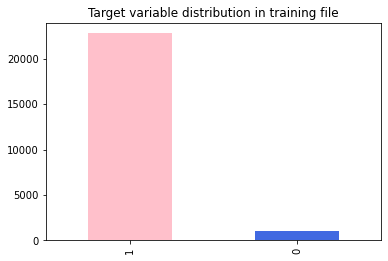

In [9]:
plt.title('Target variable distribution in training file')
train.MULTIPLE_OFFENSE.value_counts().plot(kind='bar',color=['pink','royalblue'])

From barplot it seems there is class imbalance . Let's exlpore more  by extracting more information from date . 

In [10]:
train_df=train.copy()
extract_day= train.DATE.str.split('-',n=1,expand=True)
train_df['day']=extract_day[0]
train_df['month']=extract_day[1]
extract_month=train_df.month.str.split('-',n=1,expand=True)
train_df['Month']=extract_month[0]
train_df['year']=extract_month[1]
train_df.drop(columns=['month','DATE'],inplace=True)

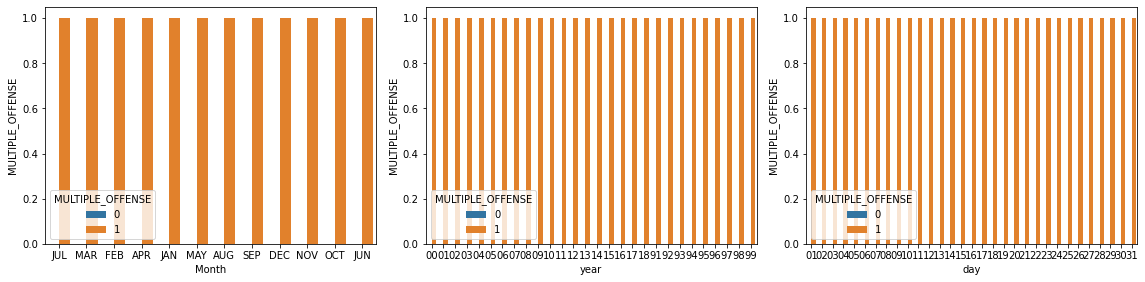

In [11]:
fg,ax=plt.subplots(nrows=1,ncols=3,figsize=(16,4))
sns.barplot(x=train_df.Month,y=train_df.MULTIPLE_OFFENSE,hue=train_df.MULTIPLE_OFFENSE,ax=ax[0])
sns.barplot(x=train_df.year,y=train_df.MULTIPLE_OFFENSE,hue=train_df.MULTIPLE_OFFENSE,ax=ax[1])
sns.barplot(x=train_df.day,y=train_df.MULTIPLE_OFFENSE,hue=train_df.MULTIPLE_OFFENSE,ax=ax[2])
fg.tight_layout(pad=1.0)

it seems that date is not affecting the prediction so will not be conisdering date as a predictor.

let's have predictors and target variables separated to train  model . Incident id and date is dropped since date & incident id  isnt affecting the prediction .

In [12]:
X=train.iloc[:,2:-1]
Y=train.iloc[:,-1]

let's build a simple xgboost model to get idea about feature importance . below cell splitting data with sklearn's train_test_split with stratification to deal with class imbalance . As the data is highly categorical  tree based models works best with this kind of data . Linear models like Linear regression / kmeans / SVM works on the principle of euclidean distances and to be able to achieve good result normalizing data is necessary . 
Since we have categorical feature rather than continous features it's better to not normalize features and instead use tree based  models. 


## splitting data and creating basic models

In [13]:
x_tr,x_ts,y_tr,y_ts=train_test_split(X,Y,stratify=Y,test_size=0.2,random_state=seed_value)
dct=DecisionTreeClassifier(random_state=seed_value)
rf=RandomForestClassifier(n_estimators=500,random_state=seed_value)
xgb=XGBClassifier(n_estimators=500)

## Comapring models

In [14]:
model=[xgb,rf,dct]
model_name=['XGBoost','RandomForest','DecisionTree']
def compare_models(models,model_name,x_tr,y_tr,x_ts,y_ts):
    scores=[]
    for i in models:
        i.fit(x_tr,y_tr)
        scores.append(recall_score(y_ts,i.predict(x_ts)))
    df=pd.DataFrame({"Model":model_name,'Score':scores})
    return(df)
compare_models(model,model_name,x_tr,y_tr,x_ts,y_ts)
    

,Model,Score
0,XGBoost,0.999342
1,RandomForest,0.999122
2,DecisionTree,0.998903


eventhough comapring models shows XGboost has given highest score lets verify that it doesnot overfit / underfit to test dataset by predicting and validating test results

Let' analysis each model with eli5 library  and have a 

In [15]:

perm=PermutationImportance(xgb,random_state=seed_value).fit(x_ts,y_ts)
weights_xgb=eli5.show_weights(perm, feature_names = x_ts.columns.tolist())
perm=PermutationImportance(rf,random_state=seed_value).fit(x_ts,y_ts)
weights_rf=eli5.show_weights(perm, feature_names = x_ts.columns.tolist())
perm=PermutationImportance(dct,random_state=seed_value).fit(x_ts,y_ts)
weights_dct=eli5.show_weights(perm, feature_names = x_ts.columns.tolist())


In [16]:
weights_xgb

Weight,Feature
0.0394 ± 0.0031,X_10
0.0350 ± 0.0022,X_11
0.0188 ± 0.0010,X_15
0.0078 ± 0.0014,X_12
0.0003 ± 0.0003,X_2
0.0002 ± 0.0000,X_14
0.0001 ± 0.0002,X_3
0 ± 0.0000,X_9
0 ± 0.0000,X_8
0 ± 0.0000,X_7


In [17]:
weights_dct

Weight,Feature
0.0790 ± 0.0027,X_10
0.0346 ± 0.0016,X_12
0.0322 ± 0.0040,X_11
0.0231 ± 0.0003,X_15
0.0003 ± 0.0003,X_6
0.0001 ± 0.0002,X_4
0.0000 ± 0.0002,X_7
0 ± 0.0000,X_14
0 ± 0.0000,X_13
0 ± 0.0000,X_9


In [18]:
weights_rf

Weight,Feature
0.0767 ± 0.0029,X_10
0.0368 ± 0.0035,X_12
0.0172 ± 0.0019,X_11
0.0054 ± 0.0020,X_15
0.0011 ± 0.0007,X_3
0.0009 ± 0.0009,X_14
0.0002 ± 0.0006,X_8
0.0002 ± 0.0004,X_5
-0.0000 ± 0.0003,X_9
-0.0001 ± 0.0003,X_1


so top features are X_10,X_12,X_11 and X_15 for all three models. As XGBoost has outperformed other two classifiers lets make final prediction using xgboost.


## hyper parameter tuning with gridsearchcv.

In [20]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=seed_value)
scores = cross_val_score(xgb, X, Y, scoring='recall', cv=cv, n_jobs=-1)

In [21]:
np.mean(scores)

0.9996928188535389

with cv val score is increased . lets try gridsearch

In [22]:

#weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param={'n_estimators':[500,100,1000,800],'max_depth':[3,5,1],'gamma':[0.1,0.01,0.001,1]}
gcv=GridSearchCV(xgb,param,n_jobs=-1,scoring='recall',cv=cv)
gcv.fit(X,Y)


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=42),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=500, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                          

In [24]:
gcv.best_score_
op=gcv.predict(test.iloc[:,2:])

In [29]:
sample=pd.DataFrame({'INCIDENT_ID':test.INCIDENT_ID})
sample['MULTIPLE_OFFENSE']=op
sample.to_csv('submission_{}.csv'.format('gcv'),index=False)

NameError: name 'i' is not defined

In [ ]:
def submission_files(models,model_name,test_data):
    for i,mod in enumerate(models):
        op=mod.predict(test_data.iloc[:,2:])
        sample=pd.DataFrame({'INCIDENT_ID':test_data.INCIDENT_ID})
        sample['MULTIPLE_OFFENSE']=op
        sample.to_csv('submission_{}.csv'.format(model_name[i]),index=False)
submission_files(model,model_name,test)
